# A/B Test: Landing Page Experiment + Logistic Regression (Case Study)
by Konrad Kuleta

**Scenario:** E-commerce landing page test for new visitors from marketing channels.

**Objective:** Evaluate whether the new landing page (**Variant B**) increases purchase probability (**conversion**) versus **Variant A**.

**Scope:** End-to-end A/B test workflow in Python:
- **Sanity checks:** Sample Ratio Mismatch (SRM) to validate the random split
- **Descriptive results:** overall conversion rates (A vs B) + uplift
- **Segmentation:** uplift by **acquisition_channel** (Paid Search, Paid Social, Organic, Email, Affiliate)
- **Model-based estimate:** logistic regression to estimate the Variant B effect while controlling for acquisition channel
- **Decision framing:** ship / don’t ship / run longer + key limitations (synthetic data)


In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# Data import
df = pd.read_csv("ab_test_data.csv", parse_dates=["date"])

## Sanity checks (SRM + basic stats)

**SRM (Sample Ratio Mismatch)** checks whether the A/B split is ~50/50 (requirement for the test validity) 

In [3]:
# A/B sample sizes
counts = df["variant"].value_counts()
print("A/B sample sizes (number of users/sessions per variant):")
print(counts)
print(f"Total N = {counts.sum():,}")


A/B sample sizes (number of users/sessions per variant):
variant
B    30079
A    29921
Name: count, dtype: int64
Total N = 60,000


In [4]:
# SRM check (chi-square) – is A/B 50/50?
from scipy.stats import chisquare
obs = counts.loc[["A","B"]].values
exp = np.array([obs.sum()/2, obs.sum()/2])

chi2, pval = chisquare(f_obs=obs, f_exp=exp)
print("SRM chi2:", round(chi2, 4), "p-value:", pval)


SRM chi2: 0.4161 p-value: 0.5189062549479662


### Conversion Rate per variant and acquisition channel

In [5]:
# Overall CR
overall = df.groupby("variant")["converted"].agg(["count","sum"])
overall["cr"] = overall["sum"] / overall["count"]
overall


,count,sum,cr
variant,,,
A,29921,1213,0.040540
B,30079,1306,0.043419


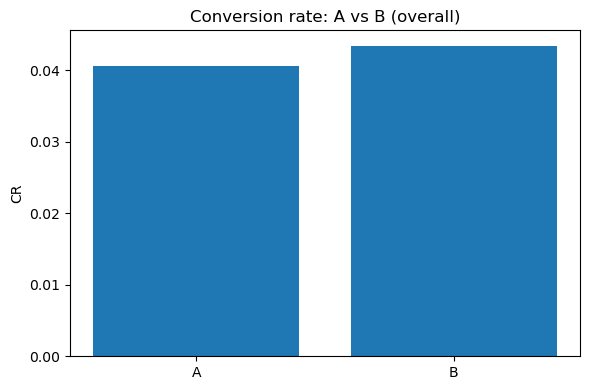

In [6]:
# Bar: overall CR A vs B
plt.figure(figsize=(6,4))
plt.bar(overall.index, overall["cr"])
plt.title("Conversion rate: A vs B (overall)")
plt.ylabel("CR")
plt.tight_layout()
plt.show()


In [7]:
# Uplift
cr_A = overall.loc["A","cr"]
cr_B = overall.loc["B","cr"]
print("Absolute lift (pp):", round((cr_B - cr_A)*100, 2), "pp")
print("Relative lift:", round((cr_B/cr_A - 1)*100, 2), "%")


Absolute lift (pp): 0.29 pp
Relative lift: 7.1 %


In [8]:
# CR per channel and variant
by_channel = df.groupby(["acquisition_channel","variant"])["converted"].agg(["count","sum"])
by_channel["cr"] = by_channel["sum"] / by_channel["count"]
by_channel.sort_values(["acquisition_channel","variant"])


count  sum        cr
acquisition_channel variant                      
Affiliate           A         3014  136  0.045123
                    B         3070  138  0.044951
Email               A         3022  212  0.070152
                    B         2992  232  0.077540
Organic             A         4465  213  0.047704
                    B         4446  257  0.057805
Paid Search         A        10587  451  0.042599
                    B        10552  493  0.046721
Paid Social         A         8833  201  0.022756
                    B         9019  186  0.020623

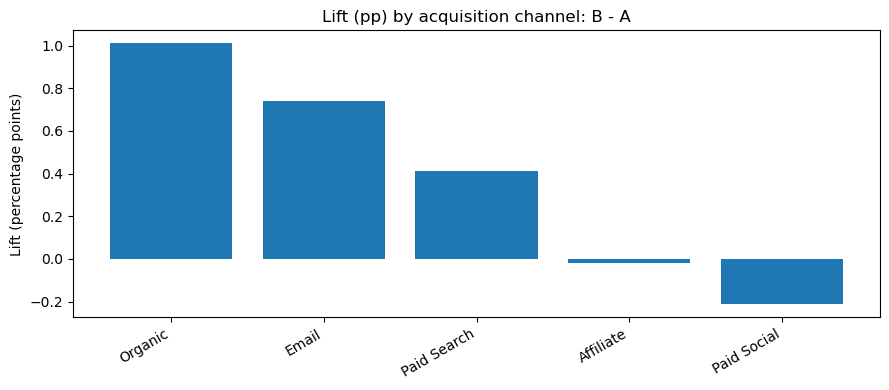

In [9]:
# Bar: uplift (B-A) per channel
pivot_ch = by_channel["cr"].unstack()
pivot_ch["lift_pp"] = (pivot_ch["B"] - pivot_ch["A"]) * 100

pivot_ch = pivot_ch.sort_values("lift_pp", ascending=False)

plt.figure(figsize=(9,4))
plt.bar(pivot_ch.index, pivot_ch["lift_pp"])
plt.title("Lift (pp) by acquisition channel: B - A")
plt.ylabel("Lift (percentage points)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


## Statistical modelling (logistic regression)

A baseline model (**Model 1**) was estimated to quantify the raw association between Variant B and conversion. Next, an adjusted model (**Model 2**) was estimated with acquisition channel included as a categorical control variable. This adjustment isolates the variant effect from differences in traffic mix, since conversion rates vary across channels. Comparing Model 1 vs Model 2 helps verify whether the observed uplift is attributable to the landing page change rather than channel composition.

In [10]:
#Data type conversion
df["variant_B"] = (df["variant"] == "B").astype(int)


### Model 1 (unadjusted A/B):
`converted ~ variant_B`
Measures the raw difference between variants.

In [11]:
#Logit model
import statsmodels.api as sm 
import statsmodels.formula.api as smf
m1 = smf.logit("converted ~ variant_B", data=df).fit(disp=False)
print(m1.summary())


                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                60000
Model:                          Logit   Df Residuals:                    59998
Method:                           MLE   Df Model:                            1
Date:                Sat, 17 Jan 2026   Pseudo R-squ.:               0.0001479
Time:                        17:27:10   Log-Likelihood:                -10450.
converged:                       True   LL-Null:                       -10452.
Covariance Type:            nonrobust   LLR p-value:                   0.07869
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1641      0.029   -107.942      0.000      -3.222      -3.107
variant_B      0.0716      0.041      1.758      0.079      -0.008       0.151


### Model 2 (adjusted for acquisition channel):
`converted ~ variant_B + C(acquisition_channel)`

In [12]:
#Logit model (adjusted)
m2 = smf.logit("converted ~ variant_B + C(acquisition_channel)", data=df).fit(disp=False)
print(m2.summary())


                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                60000
Model:                          Logit   Df Residuals:                    59994
Method:                           MLE   Df Model:                            5
Date:                Sat, 17 Jan 2026   Pseudo R-squ.:                 0.01808
Time:                        17:27:12   Log-Likelihood:                -10263.
converged:                       True   LL-Null:                       -10452.
Covariance Type:            nonrobust   LLR p-value:                 1.637e-79
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.0933      0.065    -47.299      0.000      -3.221      -2.965
C(acquisition_channel)[T.Email]           0.5255  

In [13]:
#Interpretation
import numpy as np

def print_or_summary(model, label):
    beta = model.params["variant_B"]
    ci_low, ci_high = model.conf_int().loc["variant_B"]
    or_ = np.exp(beta)
    or_low, or_high = np.exp(ci_low), np.exp(ci_high)
    pct = (or_ - 1) * 100
    pval = model.pvalues["variant_B"]
    print(f"{label}: OR(B vs A) = {or_:.3f} (~{pct:.1f}% higher odds), 95% CI [{or_low:.3f}, {or_high:.3f}], p={pval:.3f}")

print_or_summary(m1, "Model 1 (A/B only)")
print_or_summary(m2, "Model 2 (+ acquisition_channel)")


Model 1 (A/B only): OR(B vs A) = 1.074 (~7.4% higher odds), 95% CI [0.992, 1.164], p=0.079
Model 2 (+ acquisition_channel): OR(B vs A) = 1.079 (~7.9% higher odds), 95% CI [0.996, 1.169], p=0.063


### Channel-related CR heterogeneity

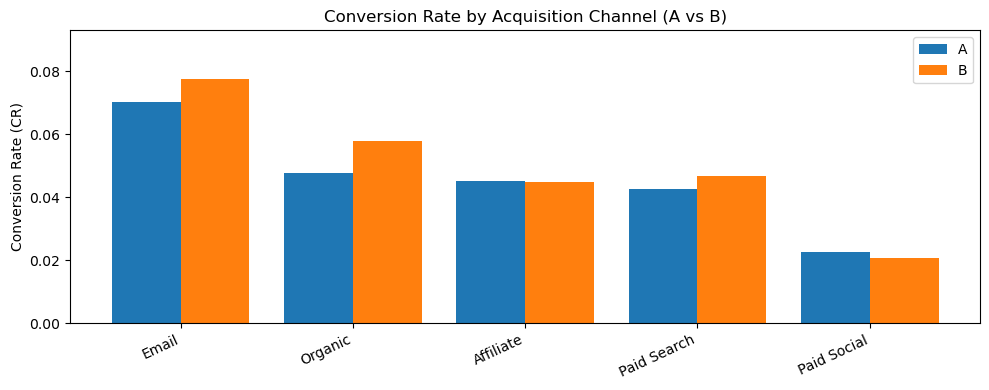

In [14]:
# CR per channel x variant
import matplotlib.pyplot as plt
cr_ch_ab = (
    df.groupby(["acquisition_channel", "variant"])["converted"]
      .mean()
      .unstack("variant")
)

# opcjonalnie sortowanie po średniej z A i B
cr_ch_ab = cr_ch_ab.loc[cr_ch_ab.mean(axis=1).sort_values(ascending=False).index]

channels = cr_ch_ab.index.tolist()
x = range(len(channels))
w = 0.4

plt.figure(figsize=(10,4))
plt.bar([i - w/2 for i in x], cr_ch_ab["A"].values, width=w, label="A")
plt.bar([i + w/2 for i in x], cr_ch_ab["B"].values, width=w, label="B")

plt.xticks(list(x), channels, rotation=25, ha="right")
plt.ylabel("Conversion Rate (CR)")
plt.title("Conversion Rate by Acquisition Channel (A vs B)")
plt.ylim(0, max(0.06, cr_ch_ab.max().max() * 1.2))
plt.legend()
plt.tight_layout()
plt.show()


## Summary

**Key findings:**
- **Randomization looks clean (SRM):** traffic split between A and B is ~50/50, so the test setup doesn’t show obvious allocation issues.
- **Overall effect is small:** Variant **B** looks *slightly* better than **A**, but the uplift is not clearly “proven” (results are borderline, could be noise).
- **Channel matters more than the variant:** conversion rates differ a lot by **acquisition_channel** — channel effects explain more of the outcome than the landing page variant alone.
- **No universal winner by channel:** some channels show higher CR for B, others don’t — treat channel splits as directional, not final truth.

**Recommendations:**
- *If it were real:* **no full-rollout** based on this alone. Either run longer / collect more data, or  a cautious rollout with monitoring.
- **Prioritize learning where it matters most:** focus next iteration on the highest-impact channels (volume or business value).


**Limitations:**
- **Synthetic dataset:** patterns are simulated and may not reflect real-world tracking noise, attribution, seasonality, or user behavior.
- **Multiple comparisons risk:** slicing by channel increases the chance of seeing “differences” that are just randomness.
- **Single outcome metric:** only conversion (no revenue/AOV/LTV), so we can’t judge business impact beyond CR.
- **Unobserved factors:** no explicit controls for time effects, device, returning users, etc. (possible hidden confounders).
